# Solving time-stationary continuity equation with secsy

Using secsy module to solve the 2D time-stationary continuity equation. 

The equation is 
$\nabla\cdot(\mathbf v n) = P - L$

I will assume that the flow is incompressible, and also that the loss term $L = \alpha n$.

Then the equation becomes
$\mathbf{v} \cdot \nabla n + \alpha n = \alpha P$

where I have multiplied the production term with $\alpha$ so that the solution becomes $n = P$ in the absence of any velocity. The matrix version of this equation becomes


$\mathrm{diag}(\mathbf{v}_e) \mathbb D_e \mathbf{n} + \mathrm{diag}(\mathbf{v}_n) \mathbb D_n \mathbf{n} + \alpha \mathbb I \mathbf{n} = \alpha\mathbf{P}$, where the vectors now denote the different quantities defined in a certain grid.

Collecting terms with $\mathbf{n}$:


$\left(\mathrm{diag}(\mathbf{v}_e) \mathbb D_e + \mathrm{diag}(\mathbf{v}_n) \mathbb D_n + \alpha \mathbb I\right) \mathbf{n} = \alpha\mathbf{P}$, which can be inverted for $\mathbf{n}$ under some conditions. 

Below I will
 1. Set up the grid
 2. Read a Weimer model output file and calculate $\mathbf{v}$ on the grid
 3. Make up some production rate on each grid cell, $\mathbf P$
 4. Solve and plot (given some loss rate $\alpha$)



In [1]:
%matplotlib inline
from secsy import cubedsphere as cs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import sparse
from scipy.ndimage import median_filter
from scipy.sparse.linalg import spsolve
from pysymmetry.utils.spherical import sph_to_car

R = 6371.2e3 # Earth radius
B0 = 3.12e-5 # Mean magnetic field
stencil_size = 3 # size of the stencil used for numerical differentiation

# set up grid:
projection = cs.CSprojection((0, 90), 0)
grid = cs.CSgrid(projection, 20000e3, 20000e3, 50e3, 50e3, R = R)
SKIP = 10 # how many grid points to skip when plotting vector fields


Next, read Weimer module output file and calculate $\mathbf v$ on the grid, assuming a dipole magnetic field

In [2]:
# read potential file:
weimer = pd.read_table('./weimer.txt', sep = ' ', skipinitialspace=True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# differentiate to get electric field components
dlat, dlon = 0.5, 2. # degrees
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt. values.reshape((181, 61)) * 15 # mlt to lon
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'linear', rescale = True).reshape(grid.shape)


# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)
E_e = -De.dot(V.flatten()).reshape(grid.shape)

# smooth the electric field a bit:
E_e = median_filter(E_e, size = 3*SKIP, mode = 'constant', cval = 0)
E_n = median_filter(E_n, size = 3*SKIP, mode = 'constant', cval = 0)

E_n[grid.lat < 60] = 0

# calculate dipole magnetic field radial components and absolute values
B_r = -2 * B0 * np.sin(grid.lat * np.pi / 180) 
B   =      B0 * np.sqrt(1 + 3 * np.sin(grid.lat * np.pi / 180)**2)

# calulate velocity components 
v_e =  E_n * B_r/B**2
v_n = -E_e * B_r/B**2

# add corotation velocity
v_e = v_e + R * np.cos(grid.lat * np.pi / 180) * 2 * np.pi / (24 * 60**2)


The next step is to make up some production pattern. I will assume that the production is dependent on the solar zenith angle, and calculate the solar zenith angle with some made-up latitude for the subsolar point

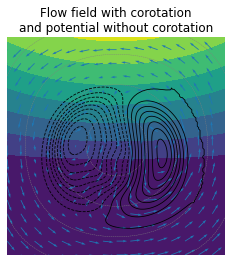

In [3]:

def get_sza(lat, lon, sslat):
    """ 
    Return solar zenith angle, in radians
    maximum value is pi/2.

    lat is the latitudes where we evaluate the sza
    lon is the *local times* where we evaluate the sza

    sslat is the latitude of the subsolar point
    """
    
    shape = lat.shape
    colat = (90 - lat).flatten() 
    lt    = lon.flatten()/15

    sslt = 12

    # compute and return the angle
    ssr = sph_to_car(np.vstack((np.ones_like(sslat), 90. - sslat, sslt * 15)), deg = True)
    gcr = sph_to_car(np.vstack((np.ones_like(colat),  colat  , lt * 15 )), deg = True)

    # the angle is arccos of the dot product of these two vectors
    sza = np.arccos(np.sum(ssr*gcr, axis = 0))
    sza[sza > np.pi/2] = np.pi/2
    return sza.reshape(shape)


P0 = 1e20 # a production scaling factor. Don't know what is realistic

sza = get_sza(grid.lat, grid.lon, 10) # last number is roughly dipole tilt angle


P = P0 * np.cos(sza)


# plot potential, velocities, and production
fig, ax = plt.subplots()
ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
ax.contourf(grid.xi, grid.eta, P.reshape(grid.shape))

vxi, veta = grid.projection.vector_cube_projection(v_e.flatten(), v_n.flatten(), grid.lon.flatten(), grid.lat.flatten(), return_xi_eta = False)
vxi, veta = vxi.reshape(grid.shape), veta.reshape(grid.shape)

ax.quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], veta[::SKIP, ::SKIP], scale = 5000, color = 'C0')

ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Flow field with corotation\nand potential without corotation')
plt.show()



Finally, construct the equation matrix and solve

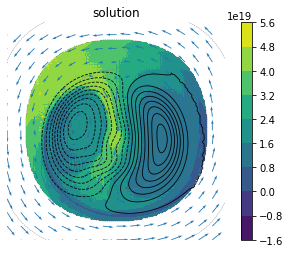

In [5]:
# first, make up some loss rate:
alpha = 5e-5 # need to think about unit for this number, and match it to P0... 

stencil_size = 2

# get differentiation matrices:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
I  = sparse.identity(grid.size)
Ve = sparse.diags(v_e.flatten())
Vn = sparse.diags(v_n.flatten())

#G = De.multiply(v_e.flatten().reshape((-1, 1))) + Dn.multiply(v_n.flatten().reshape((-1, 1))) + alpha * I
G = Ve * De + Vn * Dn + alpha * I

n = spsolve(G, alpha* P.flatten())

n[grid.lat.flatten() < 60] = np.nan

# plot potential, velocities, and solution
fig, ax = plt.subplots()
ax.contour( grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.contour( grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
c = ax.contourf(grid.xi, grid.eta, n.reshape(grid.shape))

ax.quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], veta[::SKIP, ::SKIP], scale = 5000, color = 'C0')

ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('solution')

plt.colorbar(c)
plt.show()
